### ANN for classification, example 2, red wine quality classification

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# pip install tensorflow
import tensorflow as tf
import keras
from keras import layers

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [32]:
# load the dataset
df = pd.read_csv("winequality-red.csv")

In [33]:
# let's see a sample of the data
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.40,0.70,0.00,1.90,0.08,11.00,34.00,1.00,3.51,0.56,9.40,5
1,7.80,0.88,0.00,2.60,0.10,25.00,67.00,1.00,3.20,0.68,9.80,5
2,7.80,0.76,0.04,2.30,0.09,15.00,54.00,1.00,3.26,0.65,9.80,5
3,11.20,0.28,0.56,1.90,0.07,17.00,60.00,1.00,3.16,0.58,9.80,6
4,7.40,0.70,0.00,1.90,0.08,11.00,34.00,1.00,3.51,0.56,9.40,5


In [34]:
# to have a bit more data in lower and higher ends, let's combine some categories
# the original distribution of the target is quite bad...
df['quality'] = df['quality'].replace({3: 4, 8: 7})
df['quality'].value_counts().sort_index()

quality
4     63
5    681
6    638
7    217
Name: count, dtype: int64

<Axes: >

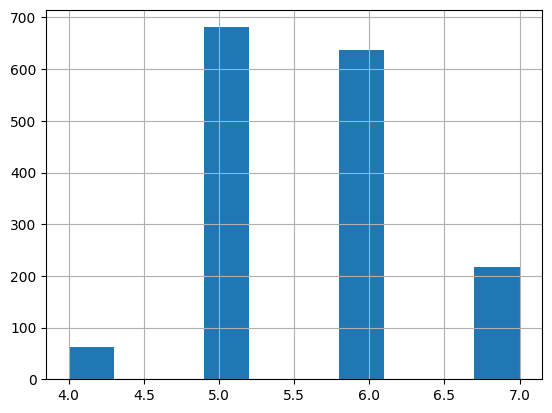

In [35]:
# still not a good distribution but let's try a neural network with this 
df['quality'].hist()

### X/y -split (note the small trick with the categories-function, int() => str())

In [36]:
# everything else except the target variable
X = df.drop("quality", axis=1)

# have only the target variable here (dependent variable)
y_temp = df['quality']

# since we are doing classification, we have to process our target values with an encoder
# and convert them into a categorical TensorFlow/Keras -format 
le = LabelEncoder()
y_enc = le.fit_transform(y_temp)

# Converting the label into a matrix form
y = tf.keras.utils.to_categorical(y_enc)

# save the categories into a helper list for later purposes
categories = list(le.classes_)

# in order to force the list of categories in string format, we can do this
# NOTE: later metrics will crash if we leave the list of categories in int() -format
# this trick maps str() -function to each value in categories
# and creates a new list from it
categories = list(map(str, categories))
categories

['4', '5', '6', '7']

### Quick SelectKBest testing

In [37]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# convert all continuous variables to integer,
# and convert all negative numbers to 0
X_cat = X.astype(int)
X_cat = X_cat.clip(lower=0)

# initialize chi2 and SelectKBest
# Note: chi2 -test is a very common test
# in statistics and quantitative analysis
# basically it studies the data whether variables are related
# or independent of each other
chi_2_features = SelectKBest(chi2, k=len(X_cat.columns))

# fit our data to the SelectKBest
best_features = chi_2_features.fit(X_cat,y.astype(int))

# use decimal format in table print later
pd.options.display.float_format = '{:.2f}'.format

# wrap it up, and show the results
# the higher the score, the more effect that column has on price
df_features = pd.DataFrame(best_features.scores_)
df_columns = pd.DataFrame(X_cat.columns)
f_scores = pd.concat([df_columns,df_features],axis=1)
f_scores.columns = ['Features','Score']
f_scores.sort_values(by='Score',ascending=False)

# many of these details make really no sense in this context
# a good example why we can't trust only a single variable selection tool
# => use multiple tools to determine the best variables to keep and drop
# AND CROSS REFENCE

,Features,Score
6,total sulfur dioxide,2730.98
5,free sulfur dioxide,160.75
1,volatile acidity,74.05
10,alcohol,46.71
2,citric acid,24.38
0,fixed acidity,11.04
3,residual sugar,5.58
9,sulphates,4.03
7,density,0.20
8,pH,0.01


**train/test/validation -split**

In [38]:
# this time, let's split the data into 70% (training data) and 30% (temporary data)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3)

# step 2, split the temporary data in HALF (0.5) => 17.5% test and 17.5% validation
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

### Create the neural network

In [39]:
# Define Sequential neural network model
# modify the input shape to match your training column count
# remember, one of the columns is removed from training columns
# to be the target value. so if your data originally had 10 columns
# the input shape is 9 ... (10 - 1 => 9)
# the input layer itself can have a different number of nodes
# Tip: have at least the same number of nodes as in the input shape
# output layer in classification depends on amount of output options in target variable
model = keras.Sequential(
    [
        layers.BatchNormalization(input_shape=(len(X.columns),)),
        layers.Dense(16, activation="relu", kernel_regularizer=keras.regularizers.l1(l1=0.1)),
        layers.Dense(8, activation="relu"),
        layers.Dense(len(categories), activation="softmax")
    ]
)

# compile the model, this time we use categorical crossentropy for loss -function
# and we also measure the accuracy of our model in the metrics
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

c:\Users\tuomas.valtanen\DL2025lecturenotes2\DeepLearning2025\.venv\Lib\site-packages\keras\src\layers\normalization\batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 11)             │            44 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │            36 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 408 (1.59 KB)

 Trainable params: 386 (1.51 KB)

 Non-trainable params: 22 (88.00 B)

In [40]:
# train/fit neural network with validation data
# see the instructions on the train/test -split above on how to split the data correctly
model.fit(x=X_train, y=y_train, epochs=500, validation_data=(X_val, y_val))

Epoch 1/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2860 - loss: 5.5388 - val_accuracy: 0.1167 - val_loss: 6.5075
Epoch 2/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3753 - loss: 4.8960 - val_accuracy: 0.1167 - val_loss: 5.1387
Epoch 3/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4084 - loss: 4.3192 - val_accuracy: 0.1208 - val_loss: 4.2809
Epoch 4/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4200 - loss: 3.7904 - val_accuracy: 0.2625 - val_loss: 3.6093
Epoch 5/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4441 - loss: 3.3080 - val_accuracy: 0.3958 - val_loss: 3.0838
Epoch 6/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4638 - loss: 2.8677 - val_accuracy: 0.4250 - val_loss: 2.6302
Epoch 7/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4674 - loss: 2.4744 - val_accuracy: 0.4500 - val_loss: 2.2410
Epoch 8/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4772 - loss: 2.1371 - val_accuracy: 0.5042 - v

**Error and performance metrics**

<Axes: >

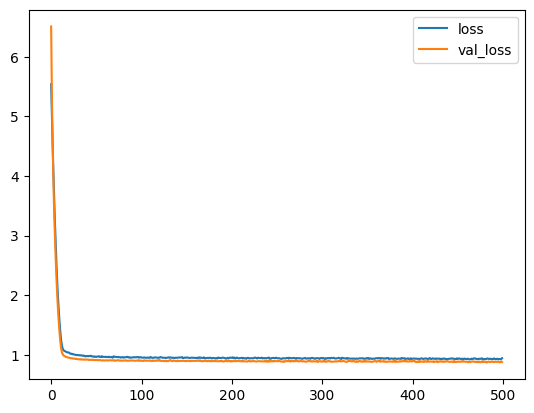

In [41]:
loss_df = pd.DataFrame(model.history.history)
loss_df[['loss', 'val_loss']].plot()

# training metrics seem ok...

<Axes: >

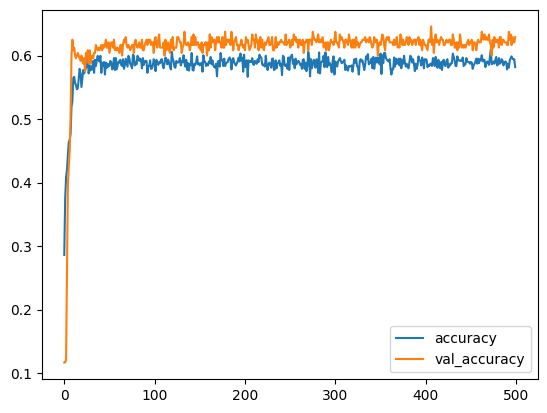

In [42]:
loss_df[['accuracy', 'val_accuracy']].plot()

# oof, accuracy caps at roughly 60%, not good

In [43]:
# compare the final model loss/accuracy/evaluation values
# the values should again match mostly
print("Test data evaluation:")
print(model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(X_train, y_train, verbose=0))

Test data evaluation:
[0.9152399301528931, 0.5833333134651184]

Train data evaluation:
[0.9172811508178711, 0.6023235321044922]


In [44]:
# get predictions and convert with argmax() to get categories 
# instead of raw probabilities
test_predictions = model.predict(X_test)
test_predictions = np.argmax(test_predictions, axis=1)

# convert also y-test -values with argmax
y_test = np.argmax(y_test, axis=1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


<Axes: >

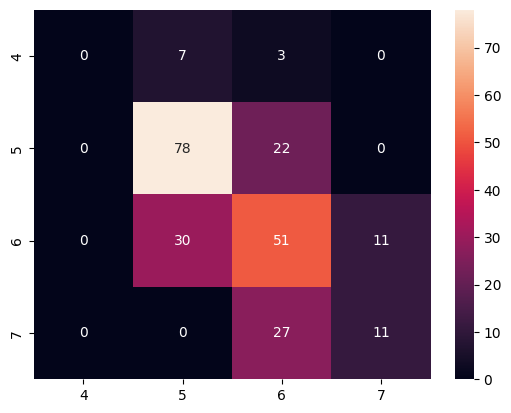

In [45]:
# confusion matrix
sns.heatmap(confusion_matrix(y_test, test_predictions), annot=True, fmt='g', 
            xticklabels=categories, yticklabels=categories)

# as we can see, most mistakes happen in neighboring classes
# the model has trouble accurately differentiating especially the 
# two average classes

# ...even though we simplified the data by combining categories 3 and 4
# as well as 7 and 8

In [46]:
# print the classification report based on true values and predictions
print(classification_report(y_test, test_predictions, target_names=categories))

# get overall accuracy of the model and print it
acc = accuracy_score(y_test, test_predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

# the model didn't recognize the category 4 AT ALL.
# really bad results this time with this model

              precision    recall  f1-score   support

           4       0.00      0.00      0.00        10
           5       0.68      0.78      0.73       100
           6       0.50      0.55      0.52        92
           7       0.50      0.29      0.37        38

    accuracy                           0.58       240
   macro avg       0.42      0.41      0.40       240
weighted avg       0.55      0.58      0.56       240


Model overall accuracy: 58.33%


c:\Users\tuomas.valtanen\DL2025lecturenotes2\DeepLearning2025\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\tuomas.valtanen\DL2025lecturenotes2\DeepLearning2025\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\tuomas.valtanen\DL2025lecturenotes2\DeepLearning2025\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to

In [47]:
# The AUC score is a super sensitive metric
# you often get low scores, even 0.5

# in binary classification, AUC values are often interpreted as follows:
# A binary classifier is useful only when it achieves ROC-AUC score greater than 0.5 and as near to 1 as possible. 
# If a classifier yields a score less than 0.5, it simply means that the model is performing worse 
# than a random classifier, and therefore is useless.

# In multi category classification , AUC values are often interpreted as follows: 
# 0.5-0.6 (failed)
# 0.6-0.7 (worthless)
# 0.7-0.8 (poor)
# 0.8-0.9 (good)
# > 0.9 (excellent)

# get ROC-AUC -score
roc_auc_score(y, model.predict(X), multi_class="ovr")

# surprisingly good ROC-AUC considering everything else

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step


0.7849453265111903